# CNN

This notebook introduces CNNs. Here, you'll approaximate the evolution operator for a conductive fluid.

For this notebook, **you need the Tensorflow, Numpy and Matplotlib libraries**. 

* One simple way to get Numpy and Matplotib is to get install Anaconda: https://docs.anaconda.com/free/anaconda/install/index.html
* Tensorflow can be installed from here: https://www.tensorflow.org/install

If you plan to do anything even moderately complex, try to get it installed with gpu support.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Set random seed for reproducible results
tf.random.set_seed(42)

This is tutorial we'll learn how to use CNN's. The data is an MHD simulations, specifically the density field of the Orszang-Tang vortex. 

The network will be used to predict the next time step.

First, we'll load the data.

In [2]:
#Load data
rho = np.load('rho.npy')

# Create the two datasets, one as input the to network, the other the predicted variable (the next time step)
# Create dummy index: needed for "color channel" in Tensorflow (none, so just one dummy index)
rho_prev = rho[:-1, :, :, np.newaxis]
rho_next = rho[1:, :, :, np.newaxis] 

# Training examples
n_train = 1000

#Training set (first 1000 time steps)
X_train = rho_prev[:n_train]
y_train = rho_next[:n_train]

#Test set (everyting after)
X_test = rho_prev[n_train:]
y_test = rho_next[n_train:]

Next, we'll create the CNN encoder-decoder. We eant the network to predict the next time step

CNN: $\rho (x,y,t) \rightarrow \rho (x,y,t + \Delta t)$


The CONV2D method combines convolution and sigma layers. If we have:

    x = Conv2D(F, (3, 3), activation='relu', padding='same', 
                  strides = 2)(inputs)

The F signifies the number of filters. The (3,3) indicates the size of filter. The other inputs are exactly what they seem: use a 'relu' activation function, pad, and take a stride length of 2. The stride means the output is half the size of the input, in the spatial indices.   

The Conv2DTranspose works like CONV3D in reverse.

![ChessUrl](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*kOThnLR8Fge_AJcHrkR3dg.gif)


In [3]:
# Number of filters in first convolutional layer
F = 4

# Number of filters in the latent space
lat_dim = 2
 
def create_encoder_decoder(input_shape=(32, 32, 1)):
    ####### Encoder ############
    
    # 32x32x1 going in
    inputs = Input(shape=input_shape)
    x = Conv2D(F, (3, 3), activation='relu', padding='same', 
              strides = 2)(inputs)
    
    # Input: 16x16xF
    x = Conv2D(2*F, (3, 3), activation='relu', padding='same',
              strides = 2)(x)
    
    ####### Latent Space #######
    # 8x8xF  =>  latent space: 8x8xlatent_dim
    x = Conv2D(lat_dim, (3, 3),  padding='same')(x)
    
    ####### Decoder ############
    # 8x8xlatent_dim
    x = Conv2DTranspose(2*F, (3, 3), activation='relu', strides = 2, 
                        padding='same')(x)
    
    # 16x16x2F
    x = Conv2DTranspose(F, (3, 3), activation='relu', strides = 2, 
                        padding='same')(x)
    
    # 32x32xF => 32x32x1
    outputs = Conv2D(1, (3, 3), activation= None, padding='same')(x)

    # Create and return the model
    model = Model(inputs, outputs)
    
    return model

# Create Model
rho_model = create_encoder_decoder()

# Print out a summary of the model
rho_model.summary()

# Compile the model (you can adjust the optimizer and loss function if you want)
rho_model.compile(optimizer='adam', loss='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 2)           146       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 8)        152       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 4)        292       
 ranspose)                                                   

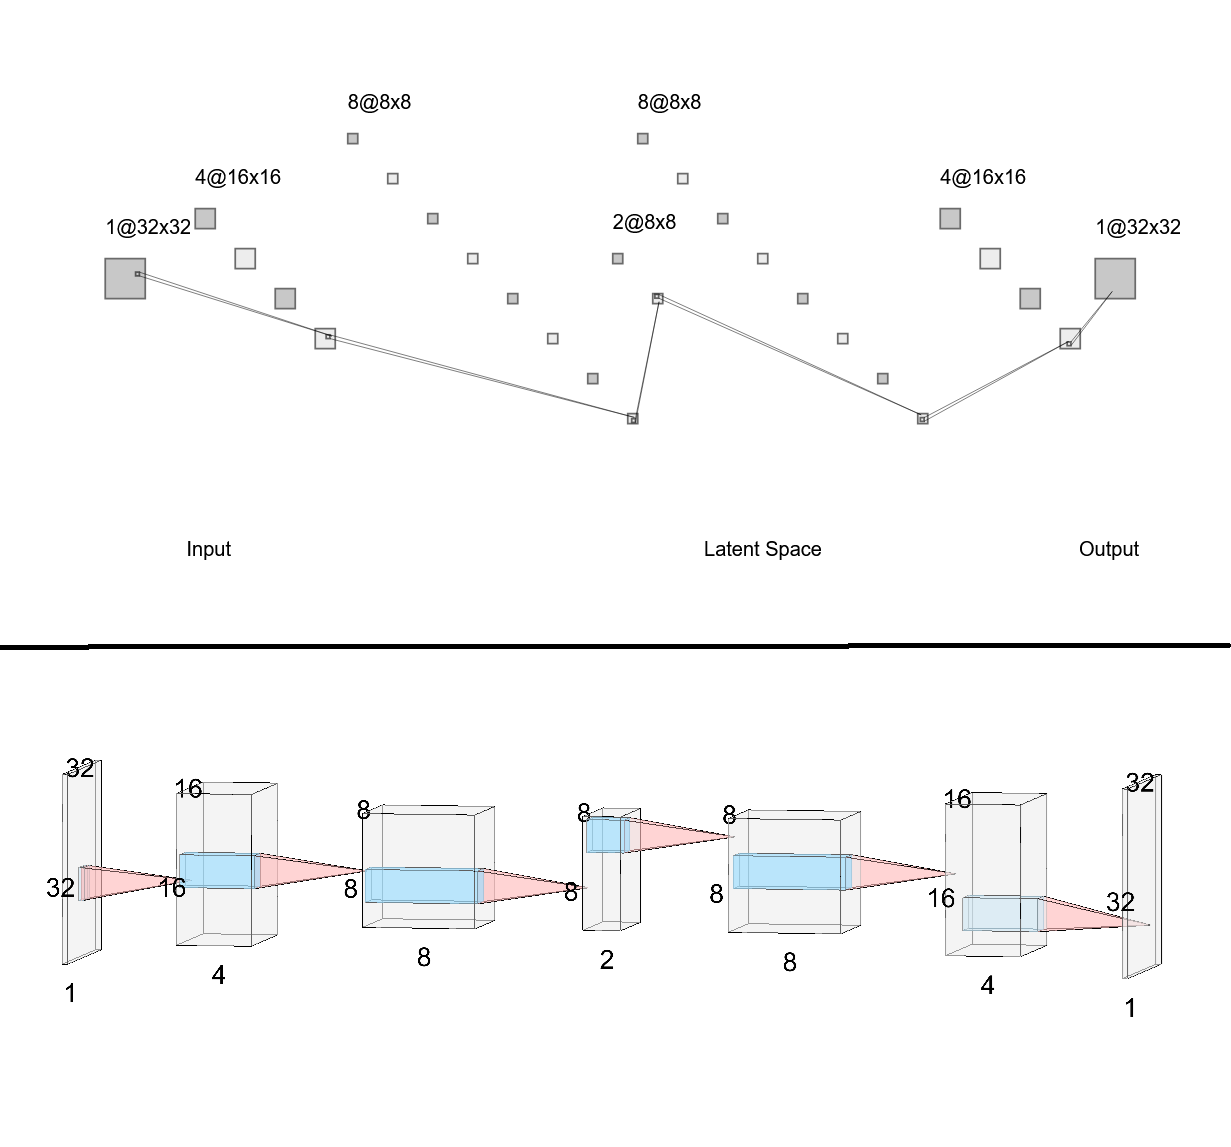

### Exercise 

1. Make sure you understand why each layer has the number of parameters it does (remember the bias terms).

In [4]:
# Fit data. Specify batch size and number of epochs to sun.
history = rho_model.fit(X_train, y_train,
                                batch_size= 4,
                                epochs=50
                                )

# Save Model
rho_model.save('rho model')

Epoch 1/50
250/250 [==============================] - 8s 4ms/step - loss: 0.0059
Epoch 2/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0016
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: 6.0976e-04
Epoch 4/50
250/250 [==============================] - 1s 5ms/step - loss: 4.1628e-04
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 3.3429e-04
Epoch 6/50
250/250 [==============================] - 1s 5ms/step - loss: 2.7748e-04
Epoch 7/50
250/250 [==============================] - 1s 5ms/step - loss: 2.3836e-04
Epoch 8/50
250/250 [==============================] - 1s 5ms/step - loss: 2.0661e-04
Epoch 9/50
250/250 [==============================] - 1s 5ms/step - loss: 1.8357e-04
Epoch 10/50
250/250 [==============================] - 1s 6ms/step - loss: 1.6410e-04
Epoch 11/50
250/250 [==============================] - 1s 5ms/step - loss: 1.4790e-04
Epoch 12/50
250/250 [==============================] - 1s 6ms/step - lo

INFO:tensorflow:Assets written to: rho model\assets


INFO:tensorflow:Assets written to: rho model\assets


Now, we plot the results and see how well it predicts.

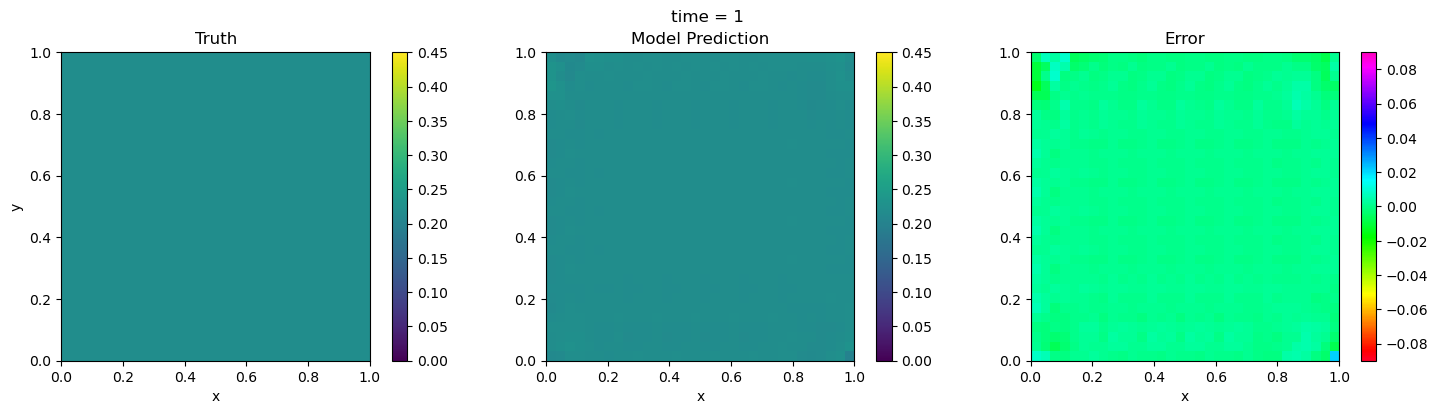

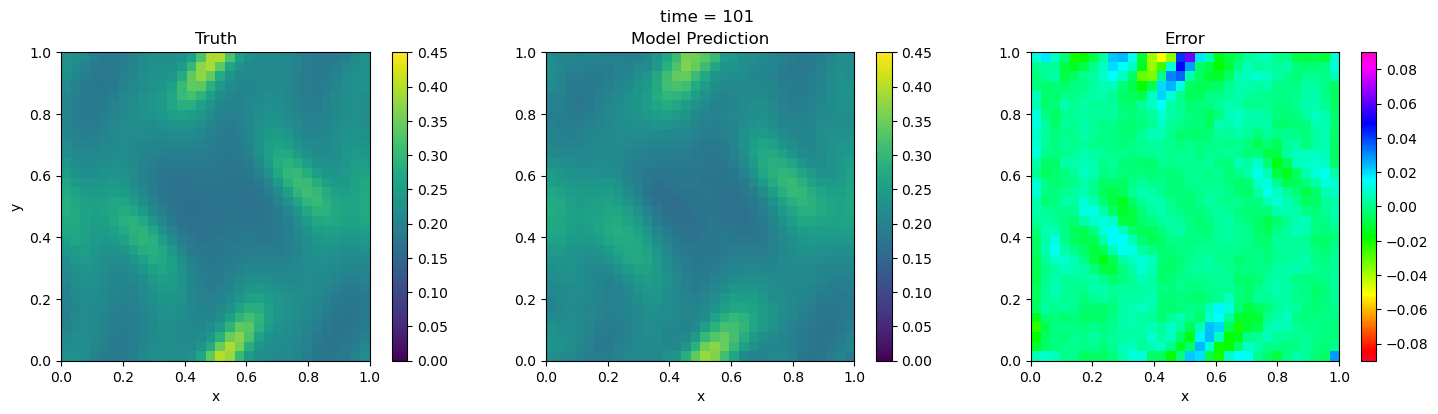

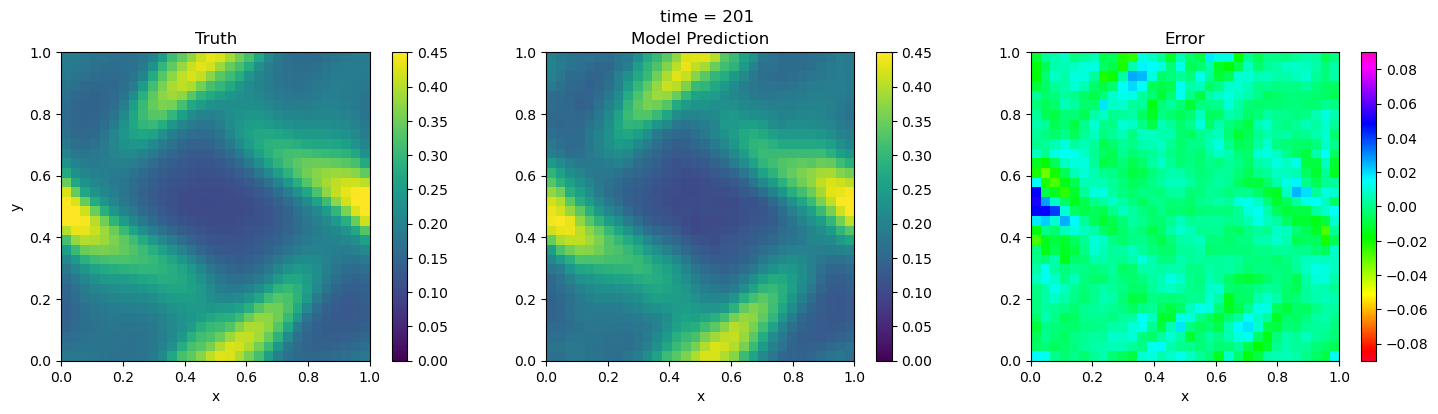

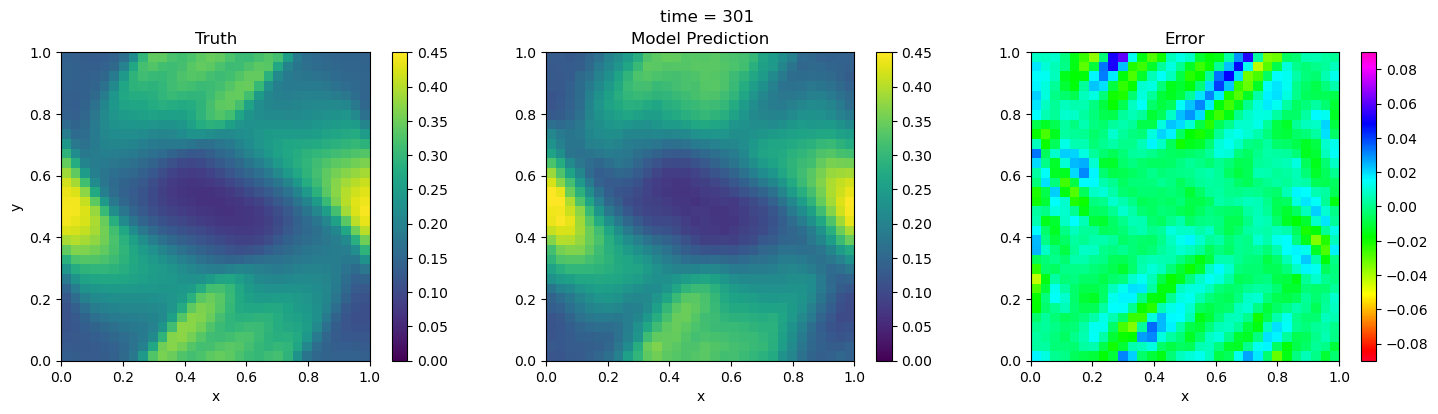

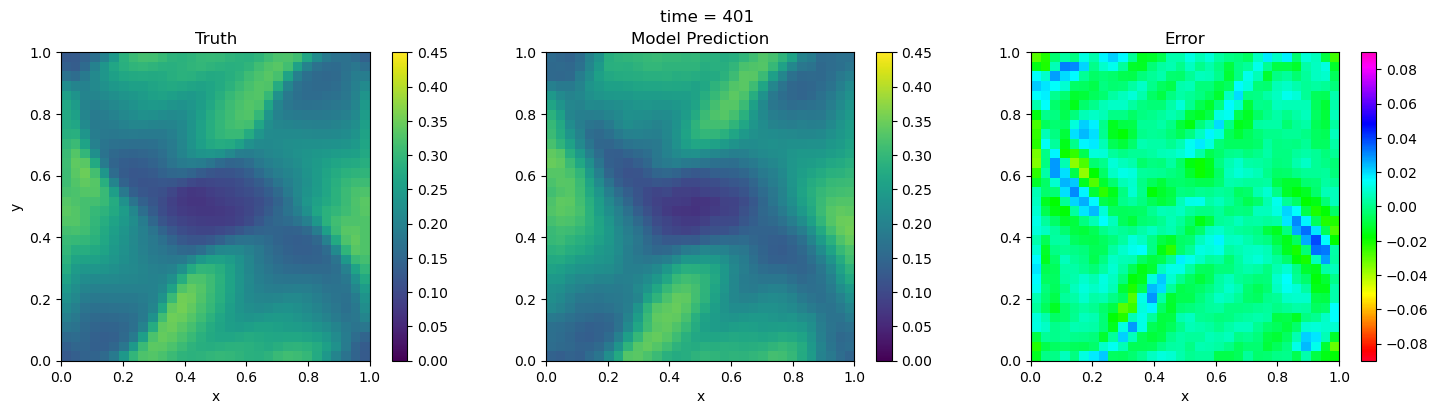

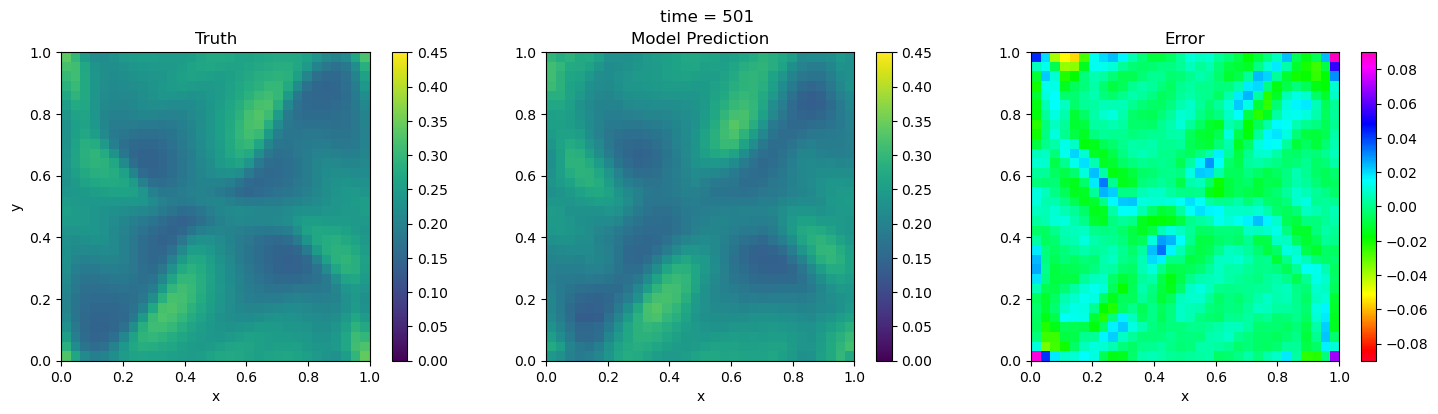

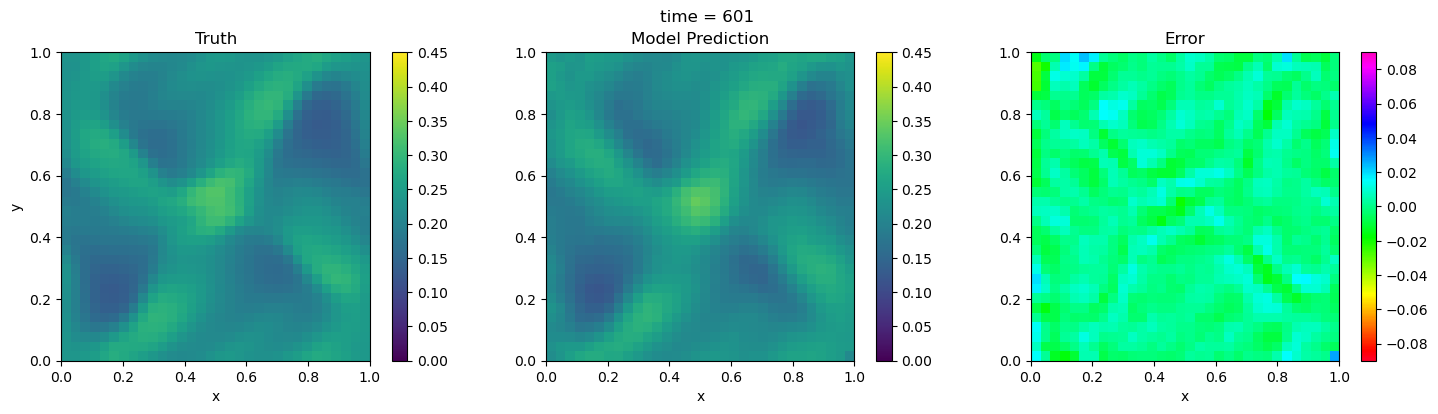

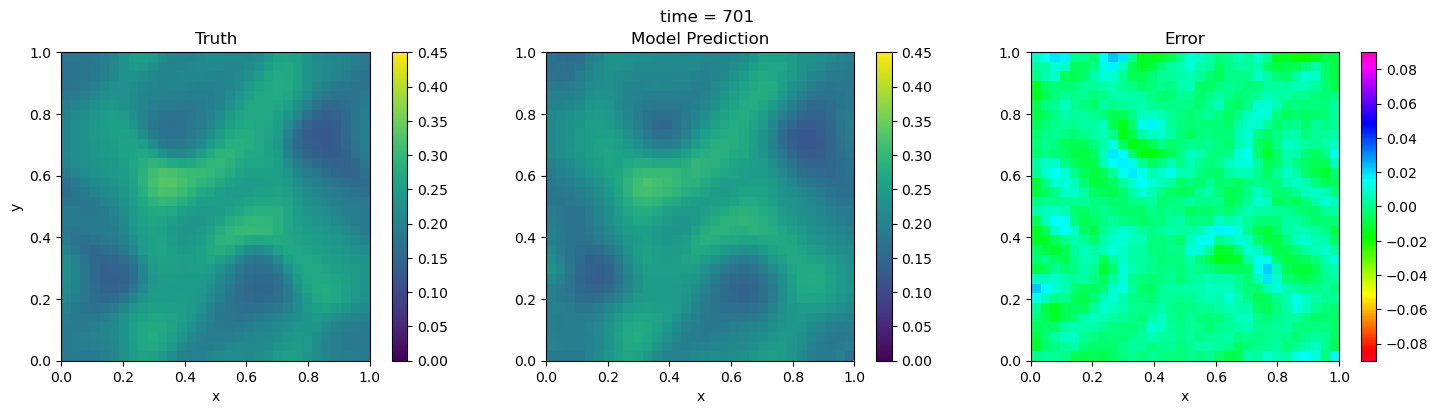

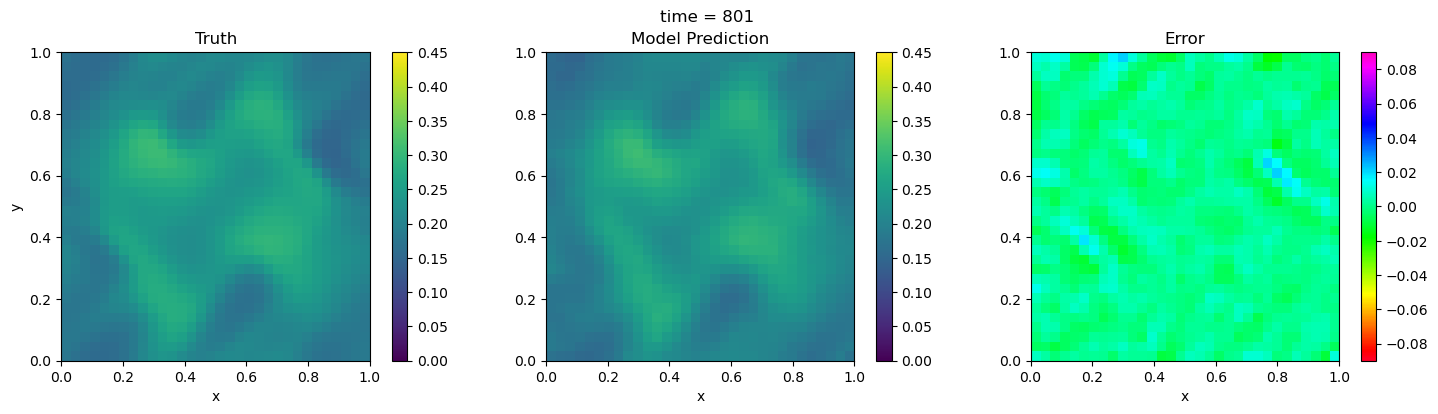

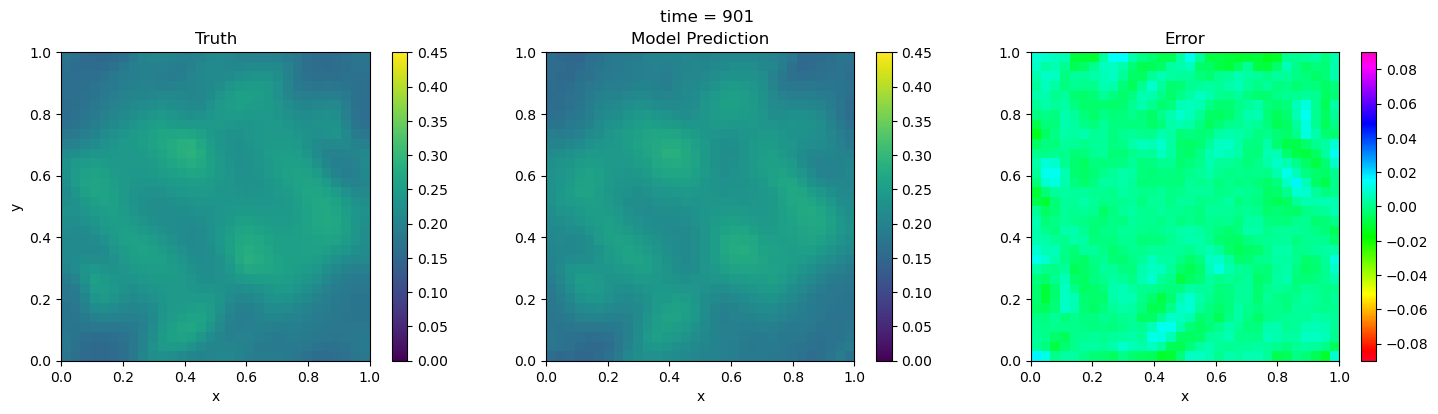

In [5]:
# Scales for plots
rho_min = 0
rho_max = 0.45
err_max = 0.09

# Plot every 100th step

for t in range(1, n_train, 100):
    plt.figure(t+1, figsize=(15,4))
    
    # Get the True Rho
    truth = rho_next[t, :, :, 0]
    
    # Get Model Prediciton
    """
    Since the model trained 4 index array (time, x, y, dummy) best
    to use 4 index array. Hence the t:t+1 term.
    Then redefine so that array is 2D
    """ 
    model_prediction = rho_model(rho_prev[t:t+1,:,:,:])
    model_prediction = model_prediction[0,:,:,0]
    
    ### Plot 1
    plt.subplot(1,3, 1)
    plt.imshow(truth.T,
               vmin = rho_min, vmax = rho_max,
               extent = [0, 1, 0, 1])
    plt.ylabel('y')
    plt.xlabel('x')
    plt.title('Truth')
    plt.colorbar()
    
    ### Plot 2
    plt.subplot(1,3, 2)
    plt.imshow(np.array(model_prediction).T,
               vmin = rho_min, vmax = rho_max,
               extent = [0, 1, 0, 1])
    plt.colorbar()
    plt.xlabel('x')
    plt.title('Model Prediction')

    
    ### Plot 3
    plt.subplot(1,3,3)
    plt.imshow(truth.T - np.array(model_prediction).T,
               vmin = -err_max, vmax = err_max,
               extent = [0, 1, 0, 1],
               cmap = 'gist_rainbow')
    plt.colorbar()
    plt.title('Error')
    plt.xlabel('x')
    
    plt.suptitle(f'time = {t}')
    plt.tight_layout()
    
# Get average error over average rho    

# Initiate
rel_err = np.zeros(n_train-1)

for t in range(n_train-1):
    # Get the True Rho
    truth = rho_next[t, :, :, 0]
    
    # Average rho value at t
    ave_rho_t = np.mean(truth)
    
    # Get Model Prediciton
    model_prediction = rho_model(rho_prev[t:t+1,:,:,:])
    model_prediction = model_prediction[0,:,:,0]
    
    # Get the average absolte error
    ave_abs_err = np.abs(np.mean(truth -model_prediction))
    
    rel_err[t] = ave_abs_err/ave_rho_t
    

Text(0, 0.5, '$\\langle|\\rho - \\hat{\\rho}| \\rangle / \\langle \\rho \\rangle$  (%)')

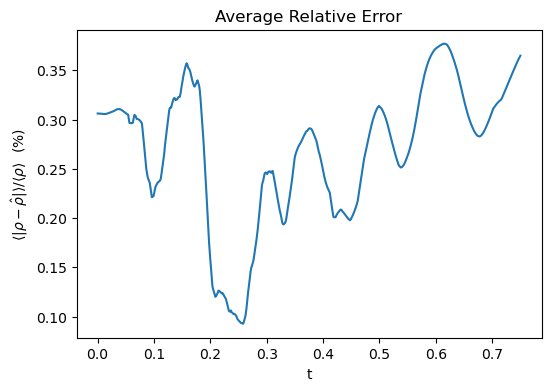

In [6]:
time = np.linspace(0,0.75, n_train-1)

plt.figure(1300, figsize=(6,4))
plt.plot(time,100*rel_err)
plt.title('Average Relative Error')
plt.xlabel('t')
plt.ylabel(r'$\langle|\rho - \hat{\rho}| \rangle / \langle \rho \rangle$  (%)')

### Exercises:

2. Now, see how the CNN does on the test set. Make it so that it takes in the last training set data, predicts the next time step and feeds the predictions into itself. See how it compres to the real thing.

3. See if you can improve the results using a Res-Net or U-Net architecture. 

4. Project idea (not easy): Predicting fluid evoltuion on the entire space can be computationally expensive because of all the degrees of freedom. One approach is to map the fluid states onto a lower dimensional latent space and look at the evolution there. Create a variational autoencoder (look it up) for the training data. Now, create another model that tracks how the motion is occuring in the latent space (LSTM, for example). See how does on the test set.